# Load Forecasting
### 1. Data manipulation

Start by merging the load data and covariate data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

In [63]:
# Read processed load data
base_dir = os.getcwd()
load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
load_data = pd.read_csv(load_file_path)
#print(load_data.head())

# Read processed temperature data
temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
avg_temperature_data = pd.read_csv(temperature_file_path)
#print(avg_temperature_data.head())

# Read processed humidity data
humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
avg_humidity_data = pd.read_csv(humidity_file_path)
#print(avg_humidity_data.head())

# Read processed solar irradiation data
solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')
avg_solar_data = pd.read_csv(solar_file_path)
#print(avg_solar_data.head())

data = load_data.copy()
data['temperature'] = avg_temperature_data['weighted_avg'].values
data['humidity'] = avg_humidity_data['weighted_avg'].values
data['solar'] = avg_solar_data['weighted_avg'].values
print(data)

                                Time (UTC)  \
0      01.01.2015 00:00 - 01.01.2015 01:00   
1      01.01.2015 01:00 - 01.01.2015 02:00   
2      01.01.2015 02:00 - 01.01.2015 03:00   
3      01.01.2015 03:00 - 01.01.2015 04:00   
4      01.01.2015 04:00 - 01.01.2015 05:00   
...                                    ...   
87667  31.12.2024 19:00 - 31.12.2024 20:00   
87668  31.12.2024 20:00 - 31.12.2024 21:00   
87669  31.12.2024 21:00 - 31.12.2024 22:00   
87670  31.12.2024 22:00 - 31.12.2024 23:00   
87671  31.12.2024 23:00 - 01.01.2025 00:00   

       Day-ahead Total Load Forecast [MW] - BZN|SE4  \
0                                            2718.0   
1                                            2660.0   
2                                            2606.0   
3                                            2600.0   
4                                            2642.0   
...                                             ...   
87667                                        2606.0   
87668  

In this section we implement the machine learning models. We start with our benchmark model which will later be used to compare the reaults of our 'advanced' models.

component            Actual Total Load [MW] - BZN|SE4
Timestamp                                            
2025-01-01 00:00:00                            2100.0
2025-01-01 01:00:00                            2089.0
2025-01-01 02:00:00                            2017.0
2025-01-01 03:00:00                            2050.0
2025-01-01 04:00:00                            2134.0
...                                               ...
2025-12-31 19:00:00                            2393.0
2025-12-31 20:00:00                            2266.0
2025-12-31 21:00:00                            2246.0
2025-12-31 22:00:00                            2172.0
2025-12-31 23:00:00                            2073.0

[8760 rows x 1 columns]


<Axes: xlabel='Timestamp'>

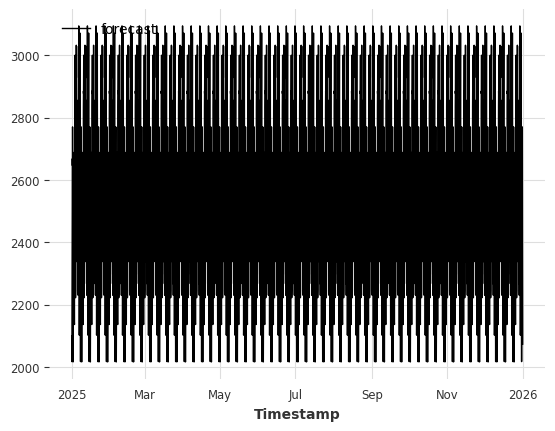

In [72]:
from darts.models import NaiveSeasonal
from darts import TimeSeries

#filepath = os.path.join("LoadData", "total_loadUTC_data.csv")
#data = pd.read_csv(filepath)
#data = pd.read_csv(filepath)

# Extract start timestamp (from "01.01.2015 00:00 - 01.01.2015 01:00")
load_data['Timestamp'] = pd.to_datetime(
    load_data['Time (UTC)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
)

# Set timestamp as index
load_data.set_index('Timestamp', inplace=True)

# Select one target column only (univariate series)
forecast_data = load_data['Actual Total Load [MW] - BZN|SE4']

# Create TimeSeries object
series = TimeSeries.from_series(forecast_data)

model = NaiveSeasonal(K=168) # weekly seasonality
model.fit(series)
pred = model.predict(8760) # change this to number of hours to be plotted
print(pred.pd_dataframe())
pred.plot(label="forecast", lw=1)

Including holidays as covariate

In [65]:
import holidays

years = np.arange(2015, 2025)

raw_holidays = []
for date, name in sorted(holidays.Sweden(years=years).items()):
    if not name == "Söndag":
        raw_holidays.append(date)
        #print(date, name)
holiday_dates = set(raw_holidays)
print(holiday_dates)

{datetime.date(2017, 5, 1), datetime.date(2020, 10, 31), datetime.date(2020, 12, 24), datetime.date(2019, 1, 1), datetime.date(2022, 4, 17), datetime.date(2021, 6, 25), datetime.date(2022, 6, 6), datetime.date(2020, 6, 6), datetime.date(2018, 12, 25), datetime.date(2016, 12, 26), datetime.date(2018, 6, 23), datetime.date(2019, 5, 30), datetime.date(2019, 11, 2), datetime.date(2021, 12, 31), datetime.date(2015, 6, 6), datetime.date(2015, 5, 14), datetime.date(2023, 6, 23), datetime.date(2024, 5, 19), datetime.date(2022, 12, 31), datetime.date(2021, 4, 5), datetime.date(2016, 1, 6), datetime.date(2019, 4, 21), datetime.date(2018, 4, 2), datetime.date(2021, 5, 13), datetime.date(2015, 5, 24), datetime.date(2020, 4, 12), datetime.date(2024, 3, 31), datetime.date(2024, 1, 6), datetime.date(2024, 3, 29), datetime.date(2016, 5, 1), datetime.date(2020, 12, 31), datetime.date(2021, 1, 6), datetime.date(2021, 4, 4), datetime.date(2018, 5, 20), datetime.date(2020, 5, 31), datetime.date(2019, 12, 

Now merge all load and covariate data into one data frame

In [ ]:
import datetime

## Alternative 1: minimal data frame, possibly bad for plotting
#data['is_holiday'] = data['Time (UTC)'].apply(
#    lambda x: datetime.datetime.strptime(x.split(' - ')[0], '%d.%m.%Y %H:%M').date() in holiday_dates
#).astype(int)

## Alternative 2: add start_time and end_time for plotting purposes
# Split time range into start and end
data[['start_time', 'end_time']] = data['Time (UTC)'].str.split(' - ', expand=True)

# Convert to datetime
data['start_time'] = pd.to_datetime(data['start_time'], format='%d.%m.%Y %H:%M')
data['end_time'] = pd.to_datetime(data['end_time'], format='%d.%m.%Y %H:%M')
data['is_holiday'] = data['start_time'].dt.date.isin(holiday_dates).astype(int)
data.to_csv('data.csv', index=False)
print(data)

                                Time (UTC)  \
0      01.01.2015 00:00 - 01.01.2015 01:00   
1      01.01.2015 01:00 - 01.01.2015 02:00   
2      01.01.2015 02:00 - 01.01.2015 03:00   
3      01.01.2015 03:00 - 01.01.2015 04:00   
4      01.01.2015 04:00 - 01.01.2015 05:00   
...                                    ...   
87667  31.12.2024 19:00 - 31.12.2024 20:00   
87668  31.12.2024 20:00 - 31.12.2024 21:00   
87669  31.12.2024 21:00 - 31.12.2024 22:00   
87670  31.12.2024 22:00 - 31.12.2024 23:00   
87671  31.12.2024 23:00 - 01.01.2025 00:00   

       Day-ahead Total Load Forecast [MW] - BZN|SE4  \
0                                            2718.0   
1                                            2660.0   
2                                            2606.0   
3                                            2600.0   
4                                            2642.0   
...                                             ...   
87667                                        2606.0   
87668  